In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [55]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/123827781.gadi-pbs'

In [3]:
# Suite for Analysis - Overview

# script needs to:
# load 1-5 variables from multiple files
# run some calculation and concatenate together
# make some plots

### first load from average files

In [9]:
# now open years 10-20

FilePath='/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/' # Truth file settings
prefix='roms_avg_'
timeRange = [21, 26]
datelist = np.array(range(timeRange[0],timeRange[1],1))

def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')


['/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0021.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0022.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0023.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0024.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0025.nc']


In [38]:
# make masks
ds['mask_zice'] = ((ds.zice<0)*ds.mask_rho)

# now make a ROI mask(s)
# plt.figure(figsize=(15,15))
# ds.mask_zice.plot(x='x_rho',y='y_rho')
# plt.grid()
poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)
ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)


In [11]:
# set any grid data here.

weights = (1/ds.pm)*(1/ds.pn)
weights.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zice + (ds.zice + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zice + ds.h) + ds.zice
    
ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
# ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')
# ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
# ds["z_rho0"] = ds.z_rho0.fillna(0)

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=0))



making vertical coordinates


In [17]:
### load forcing file

ds_frc = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
ds_frc

<xarray.Dataset>
Dimensions:   (swf_time: 365, eta_rho: 750, xi_rho: 900)
Coordinates:
  * swf_time  (swf_time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    swflux    (swf_time, eta_rho, xi_rho) float64 ...

In [21]:
ds['ssflux_corr']=ds.ssflux/ds.salt.isel(s_rho=-1)

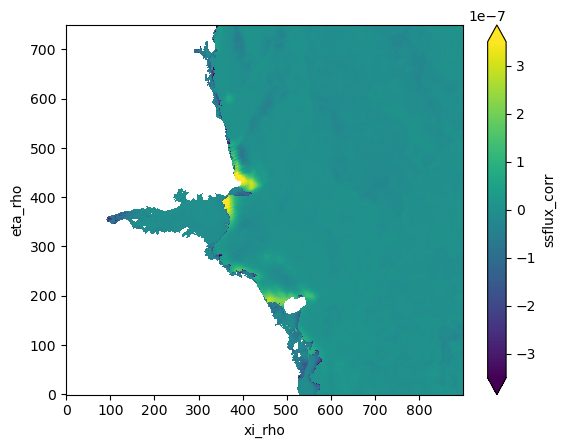

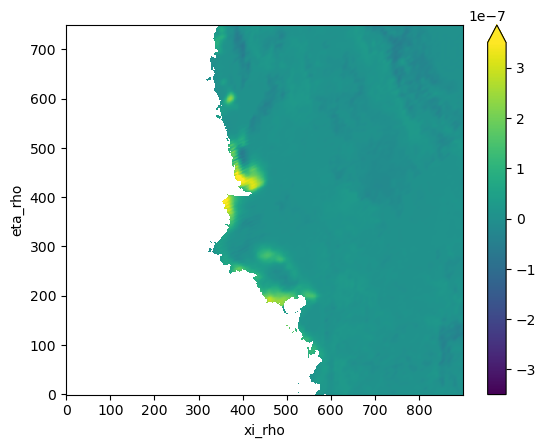

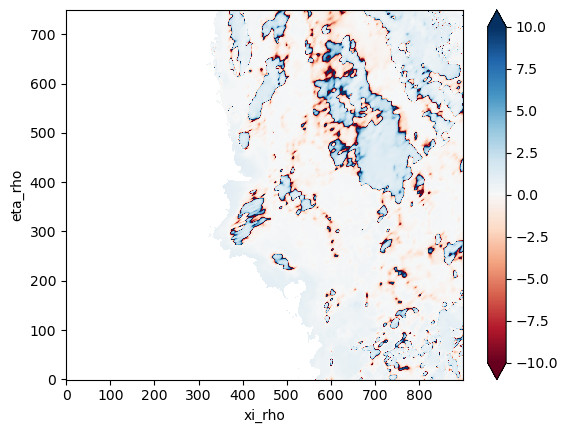

In [59]:
# compare the ratio of surface fluxes, first mean over whole year
ds.ssflux_corr.mean(dim='ocean_time').plot(vmin=-3.5e-7,vmax=3.5e-7)
plt.show()
(ds_frc.swflux.mean(dim='swf_time')*ds.mask_openoceanNaN).plot(vmin=-3.5e-7,vmax=3.5e-7)
plt.show()
(ds.ssflux_corr.mean(dim='ocean_time')/(ds_frc.swflux.mean(dim='swf_time')*ds.mask_openoceanNaN)).plot(vmin=-10,vmax=10,cmap='RdBu')


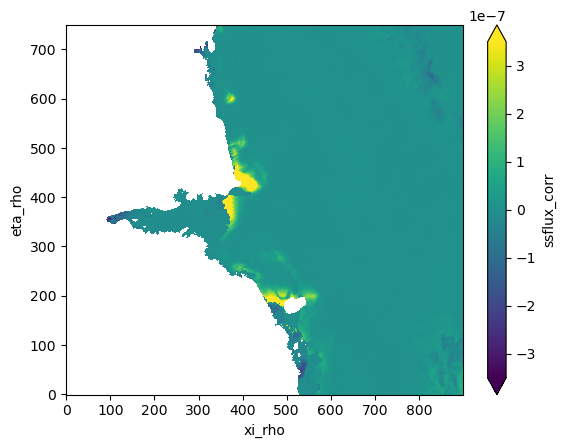

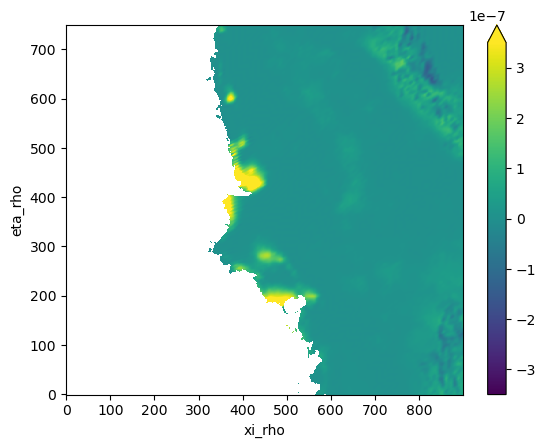

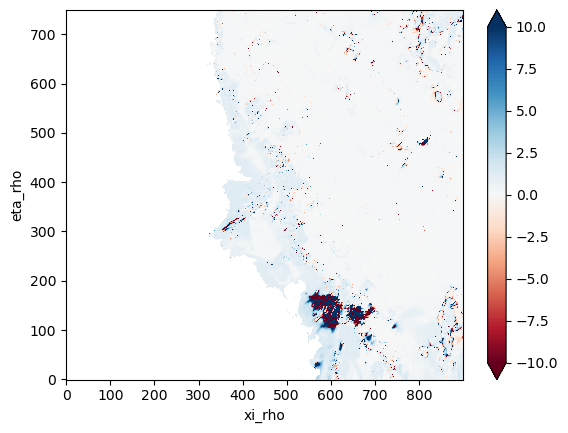

In [65]:
# now look at the average of sea ice season, say aug-october
ds.ssflux_corr.sel(ocean_time=slice('2027-08-01','2027-10-01')).mean(dim='ocean_time').plot(vmin=-3.5e-7,vmax=3.5e-7)
plt.show()
(ds_frc.swflux.sel(swf_time=slice(213,274)).mean(dim='swf_time')*ds.mask_openoceanNaN).plot(vmin=-3.5e-7,vmax=3.5e-7)
plt.show()
(ds.ssflux_corr.sel(ocean_time=slice('2027-08-01','2027-10-01')).mean(dim='ocean_time')/(ds_frc.swflux.sel(swf_time=slice(213,274)).mean(dim='swf_time')*ds.mask_openoceanNaN)).plot(vmin=-10,vmax=10,cmap='RdBu')


In [67]:
# now take some sample points and integrate the ssflux, etc
cd_xi=390
cd_eta=442

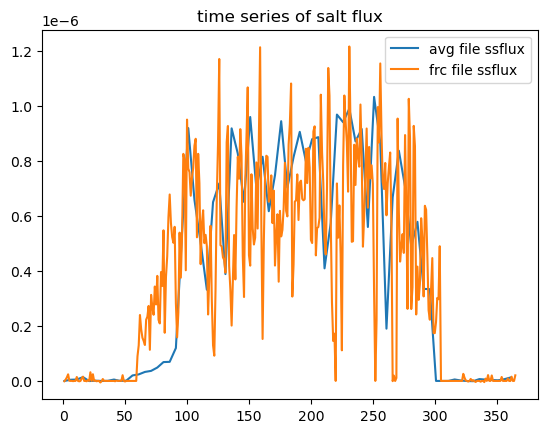

In [75]:
plt.plot(np.arange(1,366,5),ds.ssflux_corr.sel(ocean_time=slice('2027-01-01','2027-12-31')).isel(xi_rho=cd_xi,eta_rho=cd_eta),label='avg file ssflux')
plt.plot(ds_frc.swf_time,ds_frc.swflux.isel(xi_rho=cd_xi,eta_rho=cd_eta),label='frc file ssflux')
plt.title('time series of salt flux')

plt.legend()
plt.show()


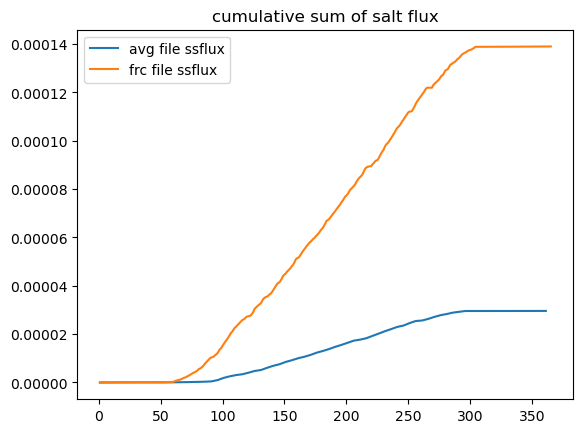

In [81]:
# now integrate/cumsum the salt.
plt.plot(np.arange(1,366,5),np.cumsum(ds.ssflux_corr.sel(ocean_time=slice('2027-01-01','2027-12-31')).isel(xi_rho=cd_xi,eta_rho=cd_eta)),label='avg file ssflux')
plt.plot(ds_frc.swf_time,np.cumsum(ds_frc.swflux.isel(xi_rho=cd_xi,eta_rho=cd_eta)),label='frc file ssflux')
plt.title('cumulative sum of salt flux')
plt.legend()
plt.show()


Text(0.5, 1.0, 'ratio of cumulative sums of salt fluxes; actual/forcing')

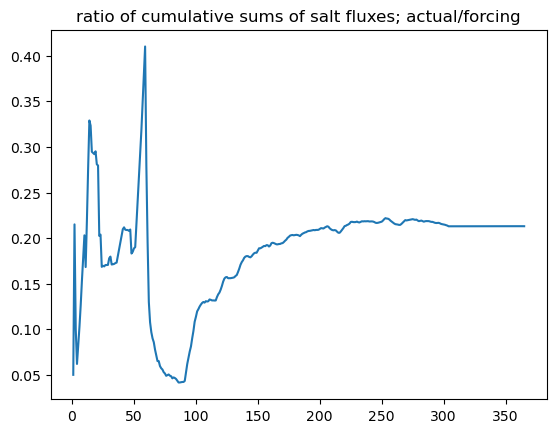

In [89]:
ds_ssflux_i = np.interp(np.arange(1,366,1),np.arange(1,366,5),np.cumsum(ds.ssflux_corr.sel(ocean_time=slice('2027-01-01','2027-12-31')).isel(xi_rho=cd_xi,eta_rho=cd_eta)))

# now plot ratio
plt.plot(np.arange(1,366,1),ds_ssflux_i/np.cumsum(ds_frc.swflux.isel(xi_rho=cd_xi,eta_rho=cd_eta)))
plt.title('ratio of cumulative sums of salt fluxes; actual/forcing')


In [ ]:
STOP

# ocean heat content

In [16]:
# plot heat content
#OHC = rho0*cp0*dV*dT
dV = (1/ds.pm)*(1/ds.pn)*ds.dz
rho0=1026
cp0=4181.3
OHC=1026*4181.3*dV*(ds.temp+273.15)

OHC2 = 1026*4181.3*dV*(ds2.temp+273.15)
OHC3 = 1026*4181.3*dV*(ds3.temp+273.15)
OHC4 = 1026*4181.3*dV*(ds4.temp+273.15)


In [17]:
# calculate totals
TotalOHC = OHC.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC2 = OHC2.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC3 = OHC3.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC4 = OHC4.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')

TotalOHC_above1000 = OHC.where((ds.z_rho>-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC2_above1000 = OHC2.where((ds.z_rho>-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC3_above1000 = OHC3.where((ds.z_rho>-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC4_above1000 = OHC4.where((ds.z_rho>-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')

TotalOHC_below1000 = OHC.where((ds.z_rho<-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC2_below1000 = OHC2.where((ds.z_rho<-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC3_below1000 = OHC3.where((ds.z_rho<-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC4_below1000 = OHC4.where((ds.z_rho<-1000).compute(), drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')


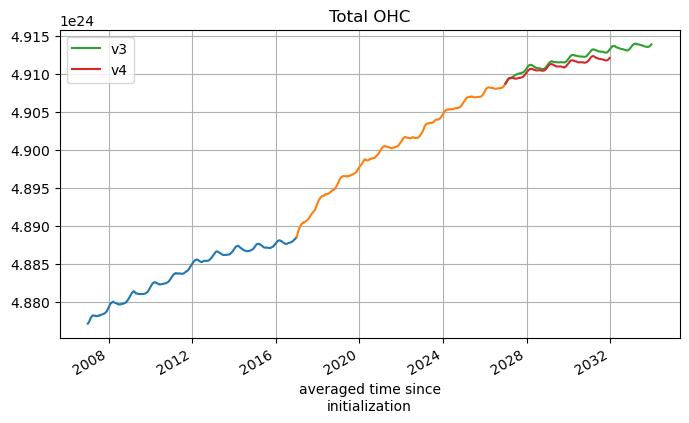

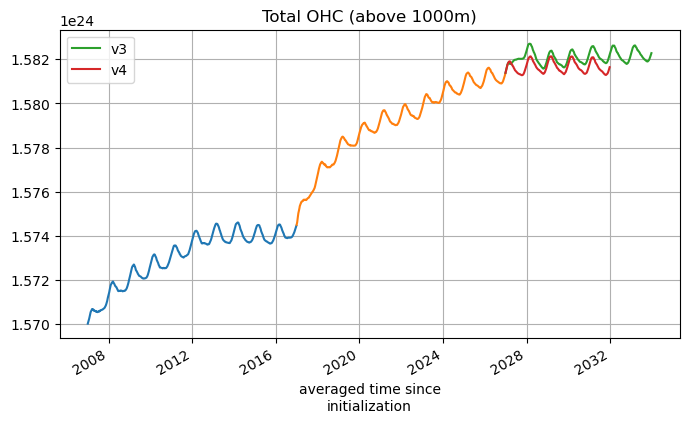

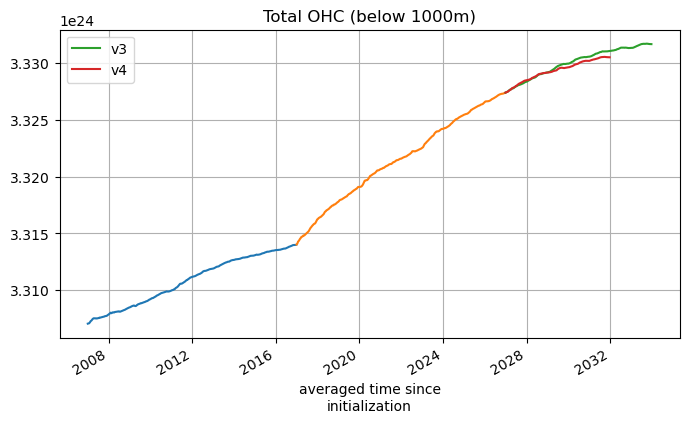

In [18]:
# plot total OHC
plt.figure(figsize=(8,4))
TotalOHC.plot()
TotalOHC2.plot()
TotalOHC3.plot(label='v3')
TotalOHC4.plot(label='v4')
plt.title('Total OHC')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
TotalOHC_above1000.plot()
TotalOHC2_above1000.plot()
TotalOHC3_above1000.plot(label='v3')
TotalOHC4_above1000.plot(label='v4')
plt.title('Total OHC (above 1000m)')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
TotalOHC_below1000.plot()
TotalOHC2_below1000.plot()
TotalOHC3_below1000.plot(label='v3')
TotalOHC4_below1000.plot(label='v4')
plt.title('Total OHC (below 1000m)')
plt.grid()
plt.legend()


Ocean heat content is slow to reach a pseudo-steady state. The shallow ocean (<1000m) HC has a seasonal cycle and begins to plateau by about year 7. The deep ocean (>1000m depth) is still responding linearly but is yet to show any plateauing.

In [19]:
# calculate OHC beneath ice
TotalOHC_subIce = OHC.where(ds.mask_zice.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC2_subIce = OHC2.where(ds.mask_zice.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC3_subIce = OHC3.where(ds.mask_zice.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC4_subIce = OHC4.where(ds.mask_zice.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')

TotalOHC_subIce_roi = OHC.where(ds.mask_zice_roi.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC2_subIce_roi = OHC2.where(ds.mask_zice_roi.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC3_subIce_roi = OHC3.where(ds.mask_zice_roi.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC4_subIce_roi = OHC4.where(ds.mask_zice_roi.compute(),drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')


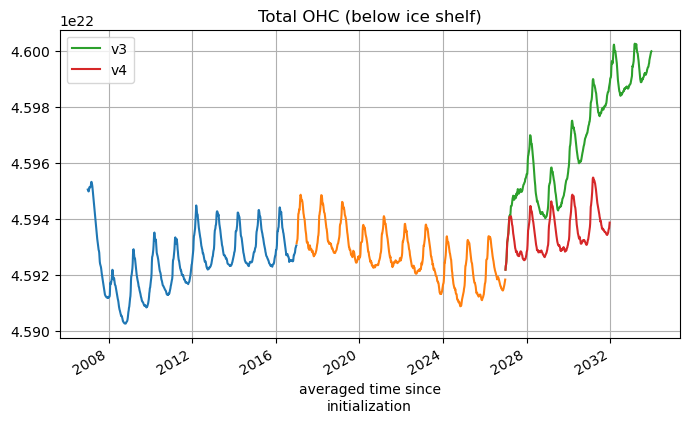

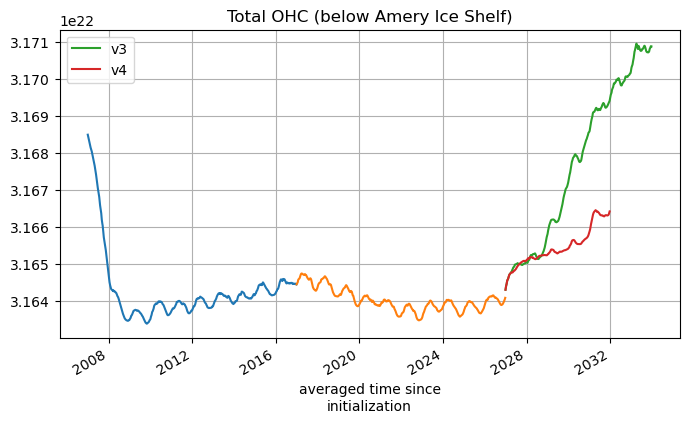

In [20]:
# plot under ice OHC

plt.figure(figsize=(8,4))
TotalOHC_subIce.plot()
TotalOHC2_subIce.plot()
TotalOHC3_subIce.plot(label='v3')
TotalOHC4_subIce.plot(label='v4')
plt.title('Total OHC (below ice shelf)')
plt.legend()
plt.grid()

plt.figure(figsize=(8,4))
TotalOHC_subIce_roi.plot()
TotalOHC2_subIce_roi.plot()
TotalOHC3_subIce_roi.plot(label='v3')
TotalOHC4_subIce_roi.plot(label='v4')
plt.title('Total OHC (below Amery Ice Shelf)')
plt.grid()
plt.legend()


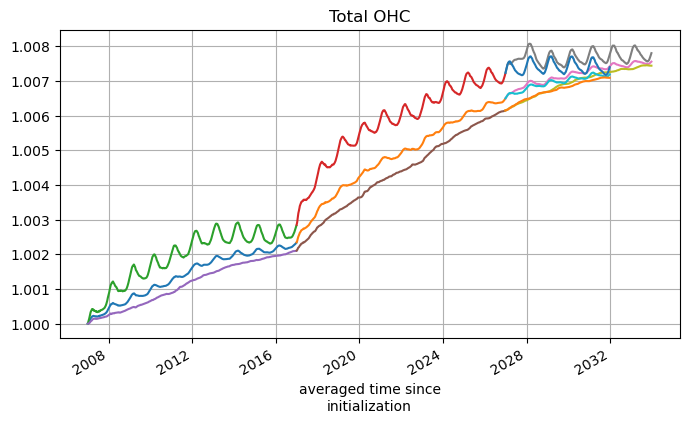

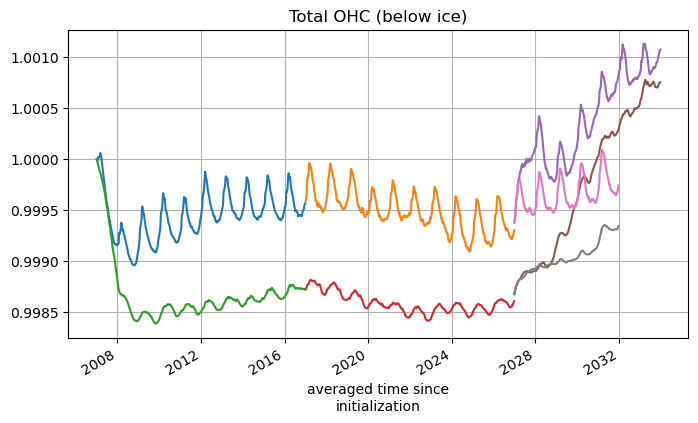

In [21]:
# plot total OHC
plt.figure(figsize=(8,4))
(TotalOHC/TotalOHC.isel(ocean_time=0)).plot(label='Total OHC')
(TotalOHC2/TotalOHC.isel(ocean_time=0)).plot()
(TotalOHC_above1000/TotalOHC_above1000.isel(ocean_time=0)).plot(label='Total OHC above 1000m')
(TotalOHC2_above1000/TotalOHC_above1000.isel(ocean_time=0)).plot()
(TotalOHC_below1000/TotalOHC_below1000.isel(ocean_time=0)).plot(label='Total OHC below 1000m')
(TotalOHC2_below1000/TotalOHC_below1000.isel(ocean_time=0)).plot()

(TotalOHC3/TotalOHC.isel(ocean_time=0)).plot(label='v3')
(TotalOHC3_above1000/TotalOHC_above1000.isel(ocean_time=0)).plot()
(TotalOHC3_below1000/TotalOHC_below1000.isel(ocean_time=0)).plot()

(TotalOHC4/TotalOHC.isel(ocean_time=0)).plot(label='v4')
(TotalOHC4_above1000/TotalOHC_above1000.isel(ocean_time=0)).plot()
(TotalOHC4_below1000/TotalOHC_below1000.isel(ocean_time=0)).plot()
plt.title('Total OHC')
plt.grid()
plt.show()


# plot under ice OHC

plt.figure(figsize=(8,4))
(TotalOHC_subIce/TotalOHC_subIce.isel(ocean_time=0)).plot(label='OHC sub ice')
(TotalOHC2_subIce/TotalOHC_subIce.isel(ocean_time=0)).plot()
(TotalOHC_subIce_roi/TotalOHC_subIce_roi.isel(ocean_time=0)).plot(label='OHC sub Amery')
(TotalOHC2_subIce_roi/TotalOHC_subIce_roi.isel(ocean_time=0)).plot()

(TotalOHC3_subIce/TotalOHC_subIce.isel(ocean_time=0)).plot(label='v3')
(TotalOHC3_subIce_roi/TotalOHC_subIce_roi.isel(ocean_time=0)).plot()

(TotalOHC4_subIce/TotalOHC_subIce.isel(ocean_time=0)).plot(label='v4')
(TotalOHC4_subIce_roi/TotalOHC_subIce_roi.isel(ocean_time=0)).plot()

plt.title('Total OHC (below ice)')
plt.grid()
plt.show()


In [22]:
del TotalOHC,TotalOHC_above1000,TotalOHC_below1000,TotalOHC_subIce,TotalOHC_subIce_roi
del TotalOHC2,TotalOHC2_above1000,TotalOHC2_below1000,TotalOHC2_subIce,TotalOHC2_subIce_roi
ds.close()

# melt rates

### have to reload ds, but now just take the m variable.


In [23]:
FilePath='/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/' # Truth file settings
prefix='roms_his_'
timeRange = [1, 11]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)


ds_m = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds_m.nbytes/1e9,'G')

['/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0001.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0002.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0003.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0004.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0005.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0006.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0007.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0008.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0009.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_his_0010.nc']
2552.470360504 G


In [24]:
ds = ds_m.drop_vars(['rho','Tb','Sb','zeta','ubar_eastward','vbar_northward','u_eastward','v_northward','temp','shflux','ssflux','sustr','svstr','angle','w','salt','zeta','f','mask_u','mask_v','mask_psi','u','v'])
print(ds.nbytes/1e9,'G')
ds


9.927878096 G


<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 750,
                    xi_rho: 900, eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900,
                    eta_psi: 749, xi_psi: 899, ocean_time: 3651)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    y_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    x_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    x_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    y_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    x_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
    y_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2007-01-01 ... 2016-12-29
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/66)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    h              (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    zice           (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pm             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pn             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    mask_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    m              (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              roms_his_0001.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Friday - August 16, 2024 -  9:...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_in...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [26]:
FilePath='/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/'
prefix='roms_avg_'
timeRange = [11, 21]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)


ds_m2 = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds_m2.nbytes/1e9,'G')

ds2 = ds_m2.drop_vars(['rho','Tb','zeta','Ustar','Tstar','ubar','vbar','u','v','temp','shflux','ssflux','sustr','svstr','angle','w','salt','f','mask_u','mask_v','mask_psi','Hsbl','AKt','AKv'])
print(ds2.nbytes/1e9,'G')
ds2


['/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0011.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0012.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0013.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0014.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0015.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0016.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0017.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0018.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0019.nc', '/g/data/gv90/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v2/roms_avg_0020.nc']
518.311134336 G
2.041154728 G


<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 750,
                    xi_rho: 900, eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900,
                    eta_psi: 749, xi_psi: 899, ocean_time: 730)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    y_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    x_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    x_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    y_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    x_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
    y_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2016-12-31T12:00:00 ... 2026-1...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/66)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    h              (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    zice           (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pm             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pn             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    mask_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    m              (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              roms_avg_0011.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Thursday - August 22, 2024 -  ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [27]:
FilePath='/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v3/'
prefix='roms_avg_'
timeRange = [21, 27]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)


ds_m3 = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds_m3.nbytes/1e9,'G')

ds3 = ds_m3.drop_vars(['rho','Tb','zeta','Ustar','Tstar','ubar','vbar','u','v','temp','shflux','ssflux','sustr','svstr','angle','w','salt','f','mask_u','mask_v','mask_psi','Hsbl','AKt','AKv'])
print(ds3.nbytes/1e9,'G')
ds3


['/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v3/roms_avg_0021.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v3/roms_avg_0022.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v3/roms_avg_0023.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v3/roms_avg_0024.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v3/roms_avg_0025.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v3/roms_avg_0026.nc']
311.0255296 G
1.252752392 G


<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 750,
                    xi_rho: 900, eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900,
                    eta_psi: 749, xi_psi: 899, ocean_time: 438)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    y_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    x_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    x_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    y_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    x_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
    y_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2026-12-29T12:00:00 ... 2032-1...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/66)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    h              (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    zice           (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pm             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pn             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    mask_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    m              (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              roms_avg_0021.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Monday - August 26, 2024 -  2:...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

In [28]:
FilePath='/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/'
prefix='roms_avg_'
timeRange = [21, 26]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)


ds_m4 = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds_m4.nbytes/1e9,'G')

ds4 = ds_m4.drop_vars(['rho','Tb','zeta','Ustar','Tstar','ubar','vbar','u','v','temp','shflux','ssflux','sustr','svstr','angle','w','salt','f','mask_u','mask_v','mask_psi','Hsbl','AKt','AKv'])
print(ds4.nbytes/1e9,'G')
ds4


['/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0021.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0022.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0023.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0024.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0025.nc']
259.204128416 G
1.055651808 G


<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 750,
                    xi_rho: 900, eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900,
                    eta_psi: 749, xi_psi: 899, ocean_time: 365)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    y_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    x_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    y_u            (eta_u, xi_u) float64 dask.array<chunksize=(750, 899), meta=np.ndarray>
    x_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    y_v            (eta_v, xi_v) float64 dask.array<chunksize=(749, 900), meta=np.ndarray>
    x_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
    y_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(749, 899), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2026-12-29T12:00:00 ... 2031-1...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/66)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    h              (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    zice           (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pm             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    pn             (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    mask_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(750, 900), meta=np.ndarray>
    m              (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 750, 900), meta=np.ndarray>
Attributes: (12/35)
    file:              roms_avg_0021.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Tuesday - August 27, 2024 -  9...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

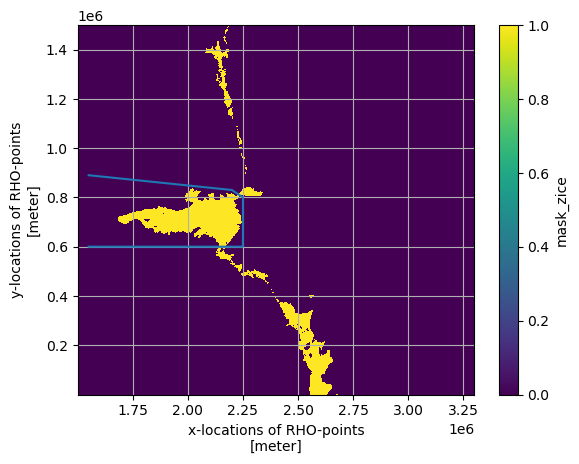

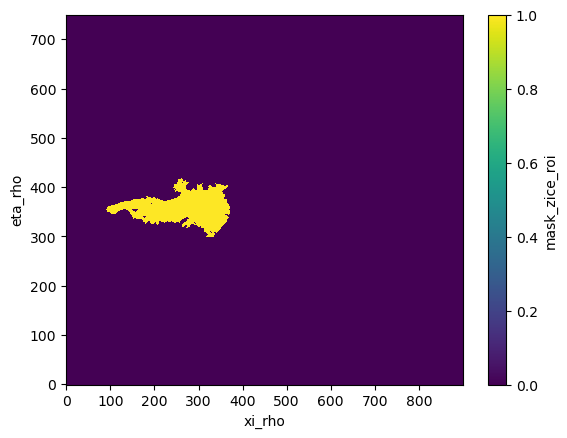

In [29]:
# make masks
ds['mask_zice'] = ((ds.zice<0)*ds.mask_rho)

# now make a ROI mask(s)
# plt.figure(figsize=(15,15))
ds.mask_zice.plot(x='x_rho',y='y_rho')
plt.grid()
poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
plt.plot(poly_shelf[:,0],poly_shelf[:,1])
plt.show()

mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

In [30]:
# implement the missing value
# ds['m'] = ds.m.where(ds.m<1e35,np.NaN)
ds['my'] = ds.m*(60*60*24*365)

# ds2['m'] = ds2.m.where(ds2.m<1e35,np.NaN)
ds2['my'] = ds2.m*(60*60*24*365)

ds3['my'] = ds3.m*(60*60*24*365)

ds4['my'] = ds4.m*(60*60*24*365)



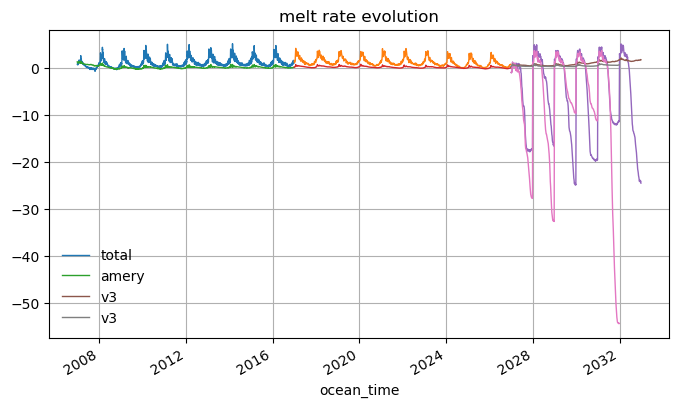

In [31]:
# time evolution of melt rate
plt.figure(figsize=(8,4))
(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='total')
(ds2.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1)

(ds.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label=roi_label1)
(ds2.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1)

(ds3.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1)
(ds3.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='v3')


(ds4.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1)
(ds4.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='v3')

plt.legend(frameon=False)
plt.title('melt rate evolution')
plt.grid()
plt.show()


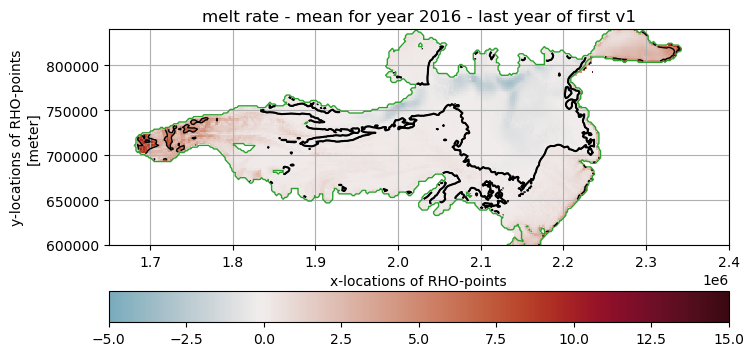

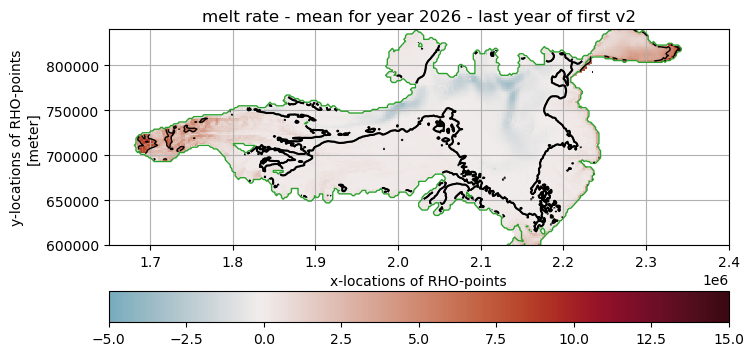

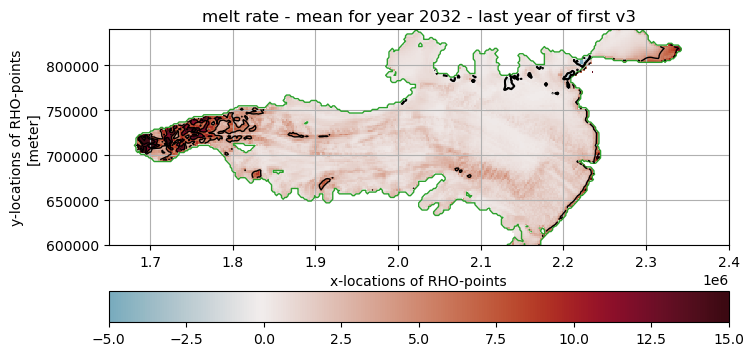

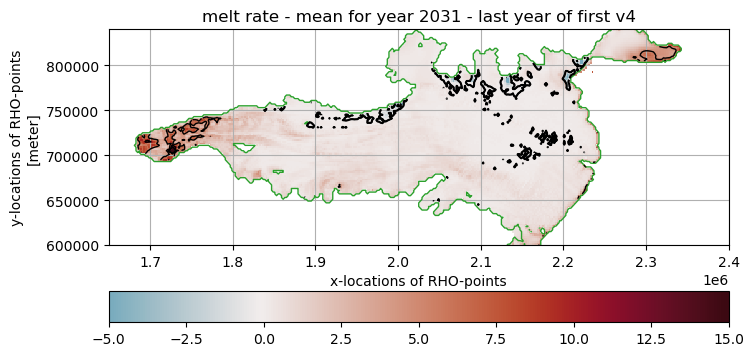

In [38]:
plt.figure(figsize=(8,4))
newcmap = cmocean.tools.crop(cmocean.cm.balance,vmin=-5,vmax=15,pivot=0)
im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2016-01-01','2017-01-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',cmap=newcmap,add_colorbar=False,vmin=-5,vmax=15)
co = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2016-01-01','2017-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=[0],colors='k')
co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2016-01-01','2017-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=np.arange(0,20,5),colors='k',linewidths=1)

plt.axis((1.65e6,2.4e6,.6e6,.84e6))
plt.title('melt rate - mean for year 2016 - last year of first v1')
plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()

plt.figure(figsize=(8,4))
newcmap = cmocean.tools.crop(cmocean.cm.balance,vmin=-5,vmax=15,pivot=0)
im=(ds2.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2026-01-01','2027-01-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',cmap=newcmap,add_colorbar=False,vmin=-5,vmax=15)
co = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds2.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2026-01-01','2027-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=[0],colors='k')
co=(ds2.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2026-01-01','2027-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=np.arange(0,20,5),colors='k',linewidths=1)

plt.axis((1.65e6,2.4e6,.6e6,.84e6))
plt.title('melt rate - mean for year 2026 - last year of first v2')
plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()

plt.figure(figsize=(8,4))
newcmap = cmocean.tools.crop(cmocean.cm.balance,vmin=-5,vmax=15,pivot=0)
im=(ds3.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2032-01-01','2033-01-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',cmap=newcmap,add_colorbar=False,vmin=-5,vmax=15)
co = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds3.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2032-01-01','2033-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=[0],colors='k')
co=(ds3.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2032-01-01','2033-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=np.arange(0,20,5),colors='k',linewidths=1)

plt.axis((1.65e6,2.4e6,.6e6,.84e6))
plt.title('melt rate - mean for year 2032 - last year of first v3')
plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()


plt.figure(figsize=(8,4))
newcmap = cmocean.tools.crop(cmocean.cm.balance,vmin=-5,vmax=15,pivot=0)
im=(ds4.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2031-01-01','2032-01-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',cmap=newcmap,add_colorbar=False,vmin=-5,vmax=15)
co = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
# co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

co=(ds4.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2031-01-01','2032-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=[0],colors='k')
co=(ds4.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice('2031-01-01','2032-01-01')).mean(dim='ocean_time').plot.contour(x='x_rho',y='y_rho',levels=np.arange(0,20,5),colors='k',linewidths=1)

plt.axis((1.65e6,2.4e6,.6e6,.84e6))
plt.title('melt rate - mean for year 2031 - last year of first v4')
plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()

In [40]:
print((ds.my.sel(ocean_time=slice('2016-01-01','2017-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').values)
print((ds2.my.sel(ocean_time=slice('2026-01-01','2027-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').values)
print((ds3.my.sel(ocean_time=slice('2032-01-01','2033-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').values)
print((ds4.my.sel(ocean_time=slice('2031-01-01','2032-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').values)




0.23551690604162648
0.1359646784874769
1.687221973557004
0.6936548721155104


mean melt rate is low!

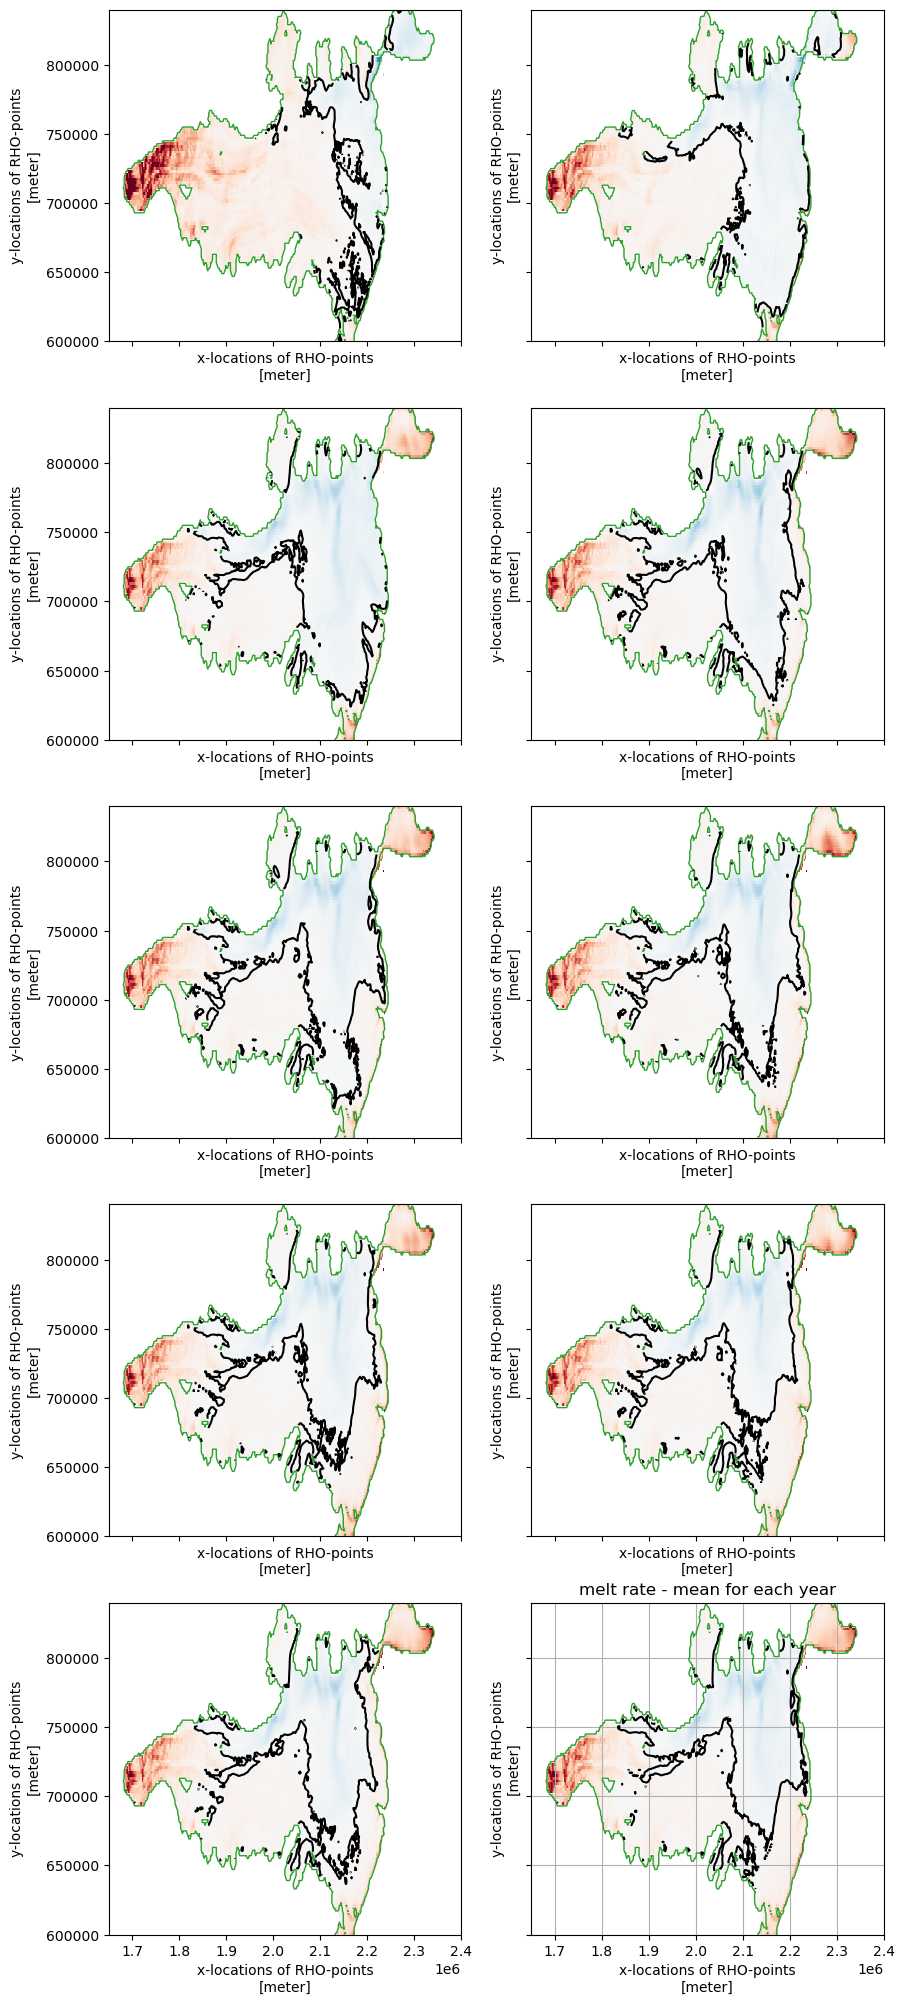

In [34]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(10,25))
newcmap = cmocean.tools.crop(cmocean.cm.balance,vmin=-5,vmax=40,pivot=0)
axes_list = axes.reshape(-1)

year_list = range(2007,2017,1)
ii=0
for year in year_list:
    ax = axes_list[ii]
    
    year_start = str(year)+'-01-01'
    year_end = str(year+1)+'-01-01'
    im=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,vmin=-10,vmax=10)
    co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
    # co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

    co=(ds.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
    ax.axis((1.65e6,2.4e6,.6e6,.84e6))
    ii=ii+1
    
plt.title('melt rate - mean for each year')
# plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()


Mean melt rate shows increasing extent of refreezing area for yr 2 compared to yr 1. Possibly reducing extent of refreezing in yr 3.

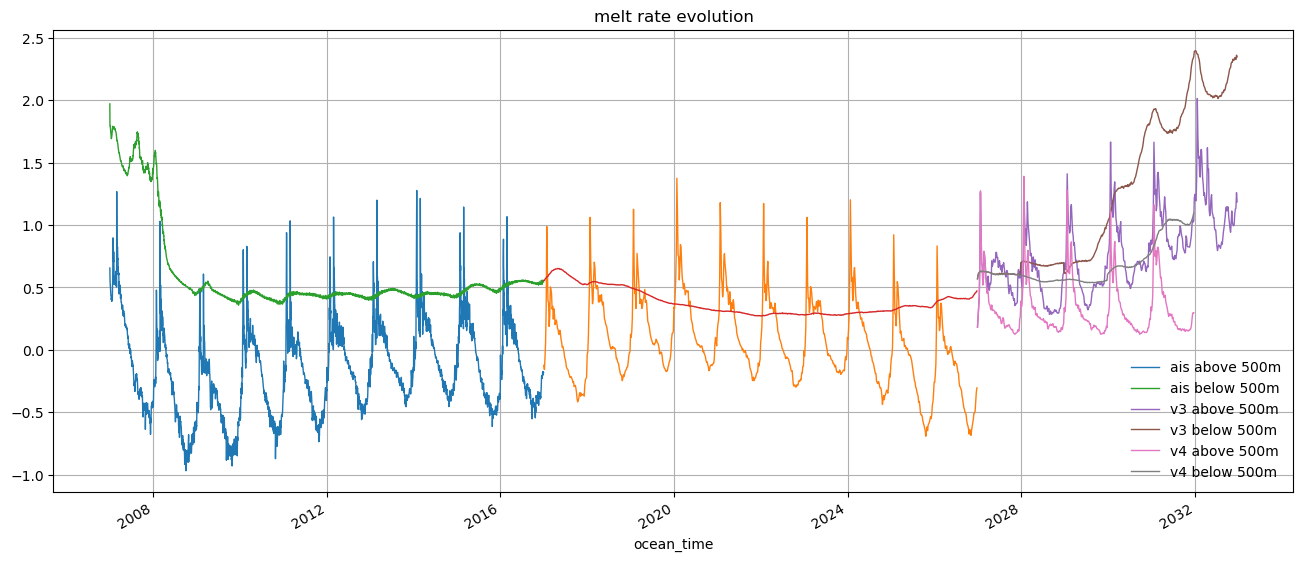

In [35]:
# time evolution of melt rate
plt.figure(figsize=(16,6))
(ds.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice>-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='ais above 500m')
(ds2.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice>-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1)

(ds.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice<-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='ais below 500m')
(ds2.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice<-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1)

(ds3.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice>-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='v3 above 500m')
(ds3.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice<-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='v3 below 500m')

(ds4.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice>-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='v4 above 500m')
(ds4.my*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).where(ds.zice<-500).weighted(weights).mean(('eta_rho','xi_rho')).plot(linewidth=1,label='v4 below 500m')

plt.legend(frameon=False)
plt.title('melt rate evolution')
plt.grid()
plt.show()


Area mean melt above 500m seasonally swings around 0m/yr. Tidal variability is clearer in below 500m melting. In the first few years, the general decrease of AIS melting to ~0m/yr average is due to the reduction in deep melting, and reinforcement in shallow refreezing. This could be indicative that the cavity overturning/barotropic circulation has not begun to feed in warmer external waters. For the last 2 years, shallow melting is /roughly/ similar, but deep melting is slowly increasing.

In [36]:
(ds2.my.sel(ocean_time=slice('2026-01-01','2027-01-01'))*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights).mean(('eta_rho','xi_rho')).mean(dim='ocean_time').values

array(0.13596468)

### v4 exploration

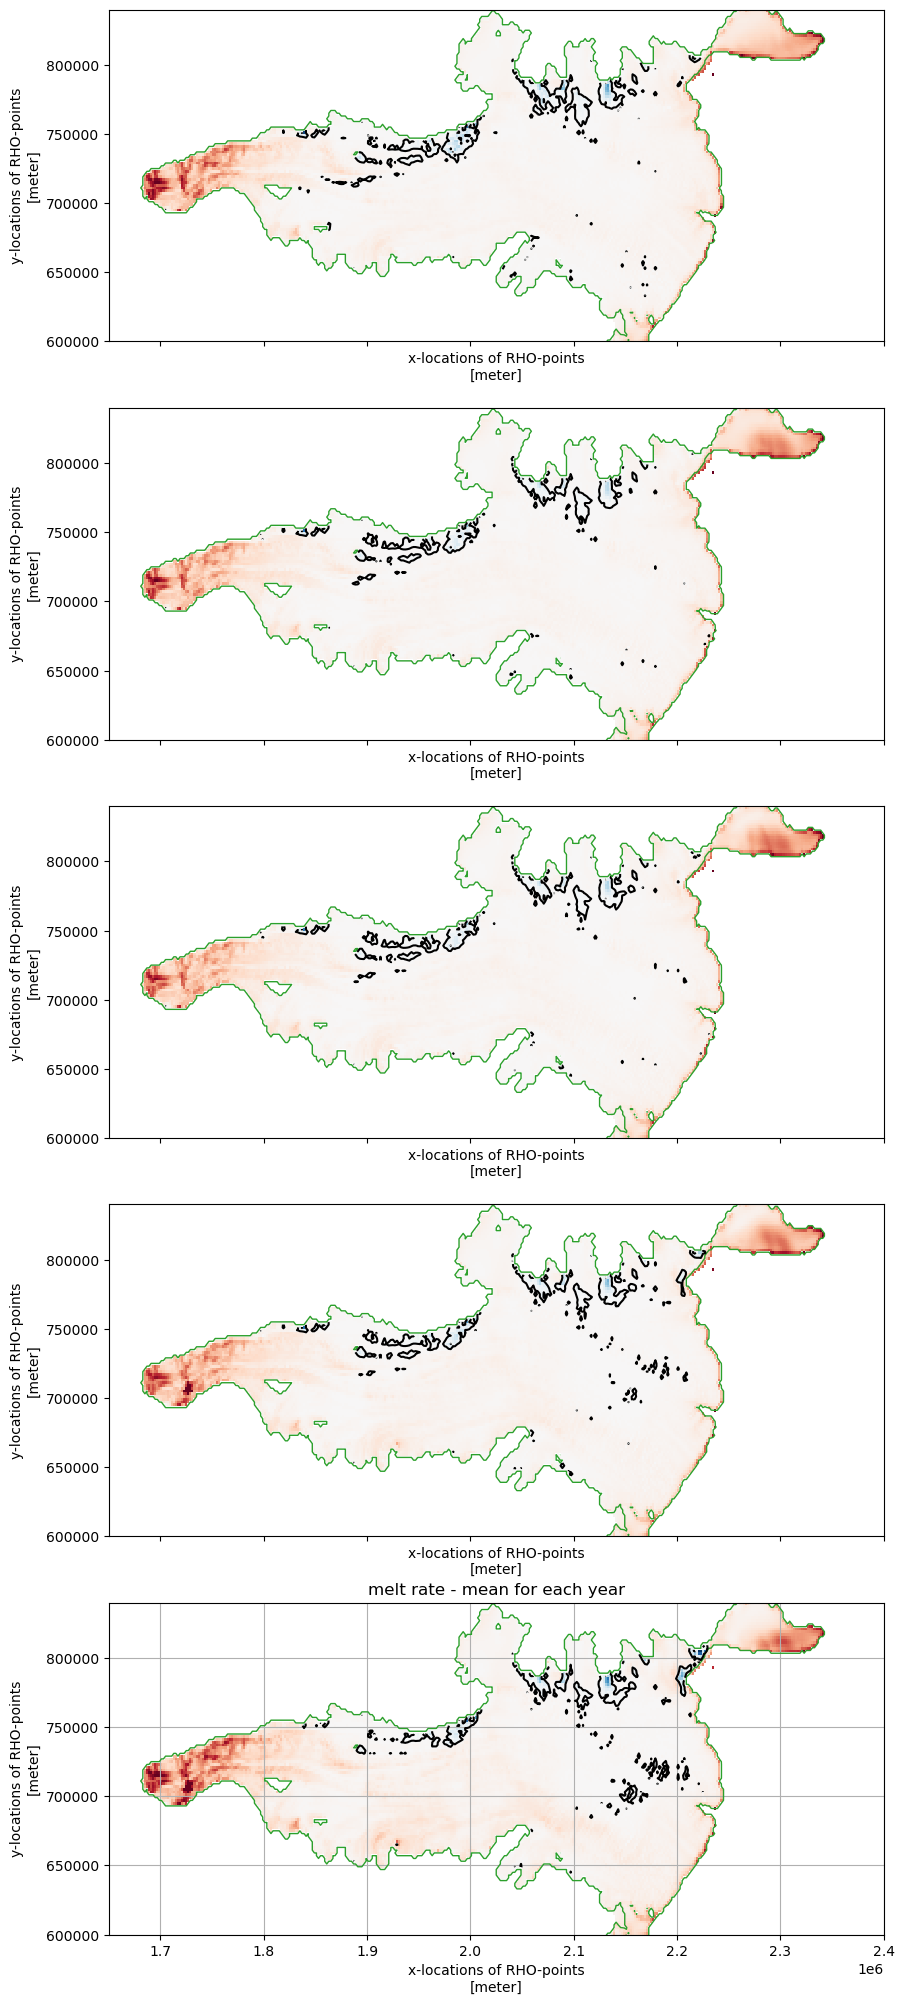

In [42]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True, figsize=(10,25))
newcmap = cmocean.tools.crop(cmocean.cm.balance,vmin=-5,vmax=40,pivot=0)
axes_list = axes.reshape(-1)

year_list = range(2027,2032,1)
ii=0
for year in year_list:
    ax = axes_list[ii]
    
    year_start = str(year)+'-01-01'
    year_end = str(year+1)+'-01-01'
    im=(ds4.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',add_colorbar=False,vmin=-10,vmax=10)
    co = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=[-1],colors='C2',linestyles='-',linewidths=1)
    # co = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='C1',linestyles='-',linewidths=0.5)

    co=(ds4.my*ds.mask_zice.where(ds.mask_zice,np.NaN)).sel(ocean_time=slice(year_start,year_end)).mean(dim='ocean_time').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=[0],colors='k')
    ax.axis((1.65e6,2.4e6,.6e6,.84e6))
    ii=ii+1
    
plt.title('melt rate - mean for each year')
# plt.colorbar(im,orientation='horizontal')
plt.grid()
plt.show()
